In [1]:
SAVE = False

Combine relevant evaluation files into a single file

In [14]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        # f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        # f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_gaussian_obs_model',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_gaussian_obs_model',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Transformer_every_valid_day_seq_len_7/00_summary_7stepsahead_interv',
        ]

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), eval_files[-1]
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='config', specifier_values=['PLRNN', 'Transformer (32)', 'Transformer (7)'])
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

if 'train_until' in combined_eval_file.columns:
    combined_eval_file.loc[combined_eval_file['latent_model']=='hierarchized clipped-shallow-PLRNN', 'latent_model'] = 'hierarchized-clipped-shallow-PLRNN'
    combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_until'] = combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_on_data_until_timestep']

Creating grand combined evaluation file                                                                                                                                                                 

Create metrics manager

In [15]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'config'], use_gt_for_predicted_difference=False, only_nonzero_differences=True)

Use mean and standard error for confidence intervals

In [16]:
metrics, errorbars = {}, {}
# m_manager.raw_metrics.loc[(12, 2, 'KalmanFilter'), 'delta_interv_change_abs_residuals'] = np.nan
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')

metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')

Plot metrics

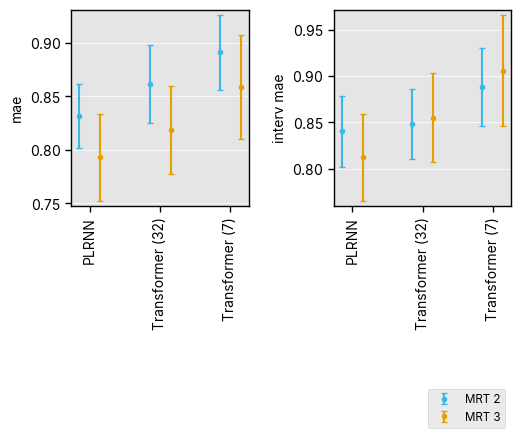

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.15, 0.15]

    ''' COMBINE BOTH MRTS INTO ONE PLOT '''
    fig, axes = plt.subplots(1, len(metrics), figsize=(1+2.2*len(metrics), 3.5), sharex=True)
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        for k, mrt in enumerate(MRT):
            this_line = metrics[m].loc[mrt]
            this_errorbars = errorbars[m].loc[mrt].T
            axes[i].errorbar(np.arange(3)+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
        ylim = axes[i].get_ylim()
        # for k, mrt in enumerate(MRT):
        #     for l, model in enumerate(model_labels.keys()):
        #         if sig[m].loc[(mrt, model), 'clipped-shallow-PLRNN']:
        #             axes[i].text(l+offset[k], ylim[1], '*', fontsize=12, color=color_cycle[k], ha='center', va='bottom')
        axes[i].set(ylabel=m, xticks=range(3))
        axes[i].set_xticklabels(['PLRNN', 'Transformer (32)', 'Transformer (7)'], rotation=90)
        adjust_ylim(axes[i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1].legend(bbox_to_anchor=(1, -0.9))
    if SAVE:
        plt.savefig('../results/_paper/model_comparison/model_comparison_every_day_ensemble.svg', dpi=300)

    plt.show()



Display metrics as table

In [18]:
human_readable_metrics = (pd.DataFrame(metrics).round(3).map(str)
                          + ' \u00b1 '
                          + pd.DataFrame(errorbars).round(4).map(str))
human_readable_metrics

mae      interv mae
MRT config                                          
2   PLRNN             0.832 ± 0.0301   0.84 ± 0.0379
    Transformer (32)  0.861 ± 0.0367  0.848 ± 0.0374
    Transformer (7)   0.891 ± 0.0347  0.888 ± 0.0424
3   PLRNN             0.793 ± 0.0406   0.812 ± 0.047
    Transformer (32)  0.819 ± 0.0411  0.855 ± 0.0485
    Transformer (7)   0.859 ± 0.0486    0.906 ± 0.06

In [20]:
test = m_manager.ttest

test_results = test('abs_residuals', separately_for_each=['MRT'])
test_results['pvalue'] *= test_results.index.get_level_values('config').unique().size - 1

if test==m_manager.ttest:
    human_readable_test_results = ('t(' 
                                   + test_results[('df', 'Transformer (7)')].astype(str)
                                   + ')='
                                   + test_results[('statistic', 'Transformer (7)')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'Transformer (7)')].map(lambda x: f"{x:.3f}"))
else:
    human_readable_test_results = ('W='
                                   + test_results[('statistic', 'Transformer (7)')].map(lambda x: f"{x:.3f}")
                                   + ', p='
                                   + test_results[('pvalue', 'Transformer (7)')].map(lambda x: f"{x:.3f}"))

human_readable_test_results

MRT  config          
2    PLRNN               t(47)=-4.196, p=0.000
     Transformer (32)    t(47)=-1.287, p=0.409
     Transformer (7)          t(47)=nan, p=nan
3    PLRNN               t(50)=-3.161, p=0.005
     Transformer (32)    t(50)=-2.200, p=0.065
     Transformer (7)          t(50)=nan, p=nan
dtype: object